In [1]:
import numpy as np
from matplotlib import pyplot as plt
import sys
from pathlib import Path

root = Path().resolve().parents[0]  # project root
sys.path.append(str(root / "src"))   # make 'resp', 'dipole', etc. importable

from biliresp.resp_parser import ParseRespDotOut

BOHR_PER_ANG = 1.8897261254578281
DEBYE_PER_E_BOHR = 2.541746

def dipole_from_charges(charges, positions_bohr, origin_bohr):
    """Return (vector_D, magnitude_D) from charges + positions in bohr."""
    charges = np.asarray(charges, dtype=float)
    positions_bohr = np.asarray(positions_bohr, dtype=float)
    origin_bohr = np.asarray(origin_bohr, dtype=float)
    rel = positions_bohr - origin_bohr[None, :]
    vec_e_bohr = (charges[:, None] * rel).sum(axis=0)
    vec_D = DEBYE_PER_E_BOHR * vec_e_bohr
    return vec_D, np.linalg.norm(vec_D)

In [2]:
resp_path = Path("../input/raw/resp.out")
n_atoms = 78  # adjust to your system

parser = ParseRespDotOut(resp_path, n_atoms)
frames = parser.extract_frames()

qm_mags = []
cl_mags = []

for frame in frames:
    if frame.dipole_moment_vector is None or frame.center_of_mass is None:
        continue  # skip incomplete frames

    qm_vec = np.asarray(frame.dipole_moment_vector, dtype=float)
    qm_mags.append(float(np.linalg.norm(qm_vec)))

    com_bohr = np.asarray(frame.center_of_mass, dtype=float) * BOHR_PER_ANG
    cl_vec, cl_mag = dipole_from_charges(frame.esp_charges, frame.positions, com_bohr)
    cl_mags.append(cl_mag)

qm_mags = np.array(qm_mags)
cl_mags = np.array(cl_mags)

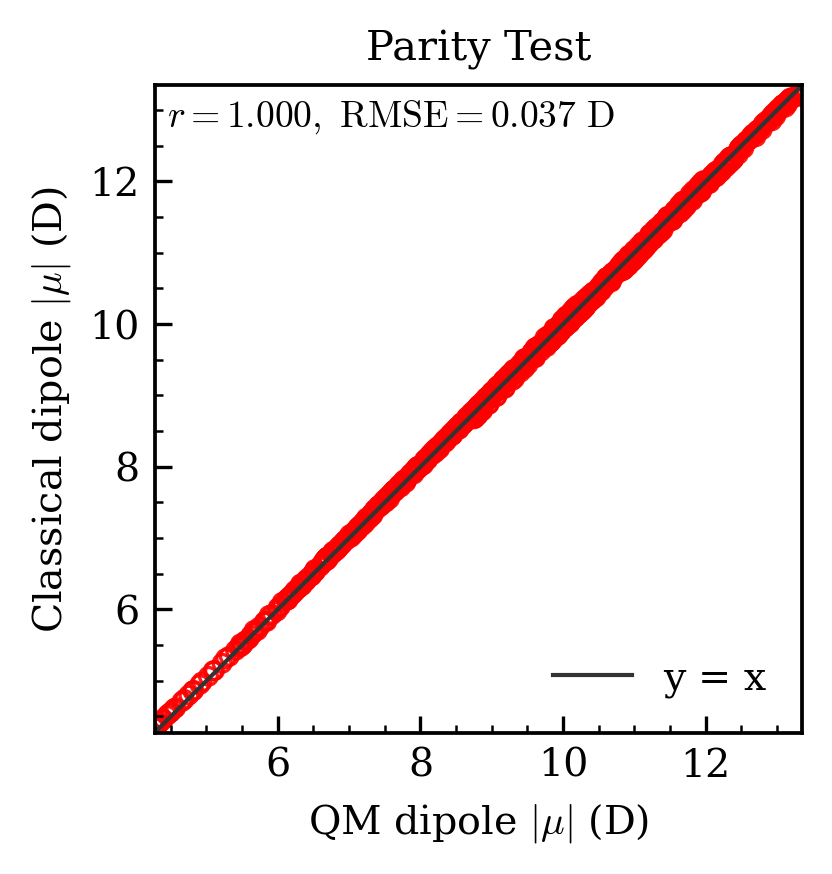

In [3]:
import matplotlib as mpl

mpl.rcParams.update({
    "figure.figsize": (3, 3),        # ≈ single-column width (PNAS/JCP style)
    "figure.dpi": 300,
    "savefig.dpi": 600,
    "savefig.bbox": "tight",
    "axes.linewidth": 0.9,
    "axes.grid": False,
    "axes.labelsize": 9.5,
    "axes.titlesize": 10,
    "font.size": 9.5,
    "font.family": "serif",
    "mathtext.fontset": "cm",            # Computer Modern-like without full LaTeX
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.minor.visible": True,
    "ytick.minor.visible": True,
    "xtick.major.size": 4,
    "ytick.major.size": 4,
    "xtick.minor.size": 2,
    "ytick.minor.size": 2,
    "xtick.major.width": 0.8,
    "ytick.major.width": 0.8,
    "xtick.minor.width": 0.6,
    "ytick.minor.width": 0.6,
    "legend.frameon": False,
})

fig, ax = plt.subplots()

# Data
# qm_mags, cl_mags = ...

# Scatter: mostly monochrome, hollow markers with crisp edges
ax.scatter(qm_mags, cl_mags, s=18, facecolors='none', edgecolors='r', linewidths=0.8, alpha=0.9)

# Parity line
lo = min(np.min(qm_mags), np.min(cl_mags))
hi = max(np.max(qm_mags), np.max(cl_mags))
ax.plot([lo, hi], [lo, hi], linestyle='-', linewidth=1.0, color="0.2", label="y = x")

ax.set_xlim(lo, hi)
ax.set_ylim(lo, hi)
ax.set_aspect('equal', adjustable='box')

ax.set_xlabel(r"QM dipole $|\mu|$ (D)")
ax.set_ylabel(r"Classical dipole $|\mu|$ (D)")
ax.set_title("Parity Test")

# Lightweight stats inset (common in group’s figures)
r = np.corrcoef(qm_mags, cl_mags)[0,1]
rmse = np.sqrt(np.mean((cl_mags - qm_mags)**2))
#ax.text(0.02, 0.98, fr"$r={r:.3f}$\nRMSE={rmse:.3f} D", transform=ax.transAxes,
#       va="top", ha="left", fontsize=9)

ax.text(
    0.02, 0.98,
    rf"$r = {r:.3f},\ \mathrm{{RMSE}} = {rmse:.3f}\ \mathrm{{D}}$",
    transform=ax.transAxes,
    va="top", ha="left",
    fontsize=9
)

ax.legend(loc="lower right")
plt.tight_layout()
#plt.show()
#plt.savefig("../reports/parity_test.pdf")  # vector export for papers
plt.savefig("../reports/../docs/img/parity_test.png")  # for docs